In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import skimage as ski
from skimage.measure import label
from skimage.color import label2rgb
from skimage.morphology import skeletonize
import cv2 as cv2

In [2]:
# read in our original image as grayscale
img = cv2.imread("tafel/Tf001.jpg", cv2.IMREAD_GRAYSCALE)

# bilateral filter
blur = cv2.bilateralFilter(img, 1, 100, 100)

# threshold
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# invert the image using bitwise_not
inverted_image = cv2.bitwise_not(thresh)

# skeletonize
skeleton = skeletonize(inverted_image)


In [3]:
plt.figure(figsize=(200,125))
plt.imshow(skeleton)

In [4]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.spatial import ConvexHull

def extract_leaf_regions_updated(image_path, landmarks, dilation_iter=2, min_area=500):
    """
    Extract grayscale, threshold, and skeleton for each leaf using convex hull masking.

    Args:
        image_path (str): Path to grayscale image.
        landmarks (list of (x, y)): List of landmark points near leaf centers.
        dilation_iter (int): Dilation iterations to connect fragments.
        min_area (int): Minimum component area to consider a valid leaf.

    Returns:
        list of (grayscale_crop, thresholded_mask, skeleton_mask)
    """
    # Load and filter
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.bilateralFilter(img, 1, 100, 100)

    # Threshold with Otsu, then invert
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)

    # Dilate to close gaps
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(inverted, kernel, iterations=dilation_iter)

    # Label connected components
    labeled = label(dilated)
    props = regionprops(labeled)

    # Associate regions to landmarks
    landmark_assignments = {}
    for i, (x, y) in enumerate(landmarks):
        min_dist = float('inf')
        assigned_label = None
        for region in props:
            if region.area >= min_area:
                cy, cx = region.centroid
                dist = np.hypot(cx - x, cy - y)
                if dist < min_dist:
                    min_dist = dist
                    assigned_label = region.label
        landmark_assignments[i] = assigned_label

    outputs = []
    for i, region_idx in landmark_assignments.items():
        if region_idx is None:
            outputs.append((None, None, None))
            continue

        # Create mask for the assigned region
        component_mask = (labeled == region_idx).astype(np.uint8)

        # Get coordinates and apply convex hull
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.shape[0] < 3:
            outputs.append((None, None, None))
            continue

        hull = ConvexHull(coords)
        hull_pts = coords[hull.vertices]
        hull_mask = np.zeros_like(component_mask)
        cv2.fillConvexPoly(hull_mask, hull_pts[:, [1, 0]], 1)

        # Use hull mask on original image
        grayscale_leaf = img * hull_mask
        thresholded_leaf = inverted * hull_mask
        skeleton_leaf = skeletonize(thresholded_leaf > 0).astype(np.uint8)

        outputs.append((grayscale_leaf, thresholded_leaf, skeleton_leaf))

    return outputs


In [5]:
import matplotlib.pyplot as plt

def visualize_leaf_segments_on_image_updated(original_image_path, leaf_outputs, show='skeleton'):
    """
    Overlays skeleton or threshold masks for each leaf on the original image.

    Args:
        original_image_path (str): Path to the original grayscale image.
        leaf_outputs (list of tuples): Output from extract_leaf_regions_updated().
        show (str): 'skeleton' or 'threshold' to control what is overlaid.
    """
    base_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    base_rgb = cv2.cvtColor(base_image, cv2.COLOR_GRAY2RGB)

    overlay = np.zeros_like(base_rgb)

    # Use a colormap that can be indexed
    colormap = plt.colormaps['tab20']
    num_colors = colormap.N

    for i, (gray, binary, skeleton) in enumerate(leaf_outputs):
        color = np.array(colormap(i % num_colors)[:3]) * 255
        color = color.astype(np.uint8)

        if show == 'threshold':
            mask = binary > 0
        elif show == 'skeleton':
            mask = skeleton > 0
        else:
            raise ValueError("show must be 'skeleton' or 'threshold'")

        for c in range(3):
            overlay[..., c][mask] = color[c]

    # Blend
    alpha = 0.6
    blended = cv2.addWeighted(base_rgb, 1 - alpha, overlay.astype(np.uint8), alpha, 0)

    # Show
    plt.figure(figsize=(12, 12))
    plt.imshow(blended)
    plt.axis('off')
    plt.title(f"Overlay of {show}s on Original Image")
    plt.show()



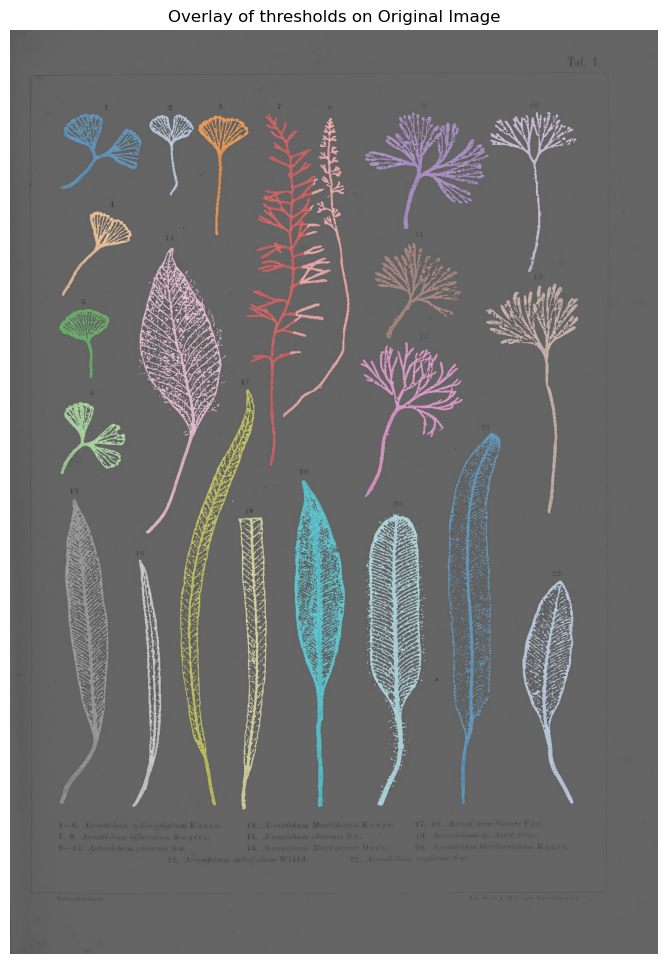

In [6]:
landmark_arr = np.loadtxt("./L001.txt")
landmarks = [tuple(coord) for coord in landmark_arr]

# Extract per-leaf outputs
leaf_data = extract_leaf_regions_updated("modTf001.tif", landmarks)

# Visualize thresholds
visualize_leaf_segments_on_image_updated("modTf001.tif", leaf_data, show='threshold')